In [17]:
import geopandas as gpd
from pyproj import CRS
import requests
import geojson
import matplotlib.pyplot as plt

In [1]:
# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format).
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018',
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

In [2]:
pop.head()

,geometry,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80
0,MULTIPOLYGON Z (((25476499.999 6674248.999 0.0...,3342,108,45,11,23,6,7,26,17,8,6,4
1,MULTIPOLYGON Z (((25476749.997 6674498.998 0.0...,3503,273,35,35,24,52,62,40,26,25,9,0
2,MULTIPOLYGON Z (((25476999.994 6675749.004 0.0...,3660,239,34,46,24,24,45,33,30,25,10,2
3,MULTIPOLYGON Z (((25476999.994 6675499.004 0.0...,3661,202,30,52,37,13,36,43,11,4,3,3
4,MULTIPOLYGON Z (((25476999.994 6675249.005 0.0...,3662,261,30,64,32,36,64,34,20,6,3,2


In [5]:
pop = pop.rename(columns={'asukkaita': 'pop18'})
pop = pop[["pop18", "geometry"]]
pop.head()

,pop18,geometry
0,108,MULTIPOLYGON Z (((25476499.999 6674248.999 0.0...
1,273,MULTIPOLYGON Z (((25476749.997 6674498.998 0.0...
2,239,MULTIPOLYGON Z (((25476999.994 6675749.004 0.0...
3,202,MULTIPOLYGON Z (((25476999.994 6675499.004 0.0...
4,261,MULTIPOLYGON Z (((25476999.994 6675249.005 0.0...


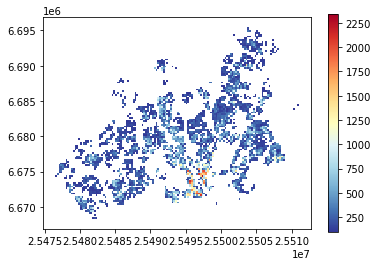

In [7]:
pop.plot('pop18', cmap='RdYlBu_r', legend=True)

In [9]:
# Addresses filpath
addr_fp = 'L3_data/addresses.shp'

# Read data
addresses = gpd.read_file(addr_fp)

addresses.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94168 60.16996)
3,"Hermannin rantatie, Hermanninranta, Hermanni, ...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97684 60.19419)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


In [10]:
addresses.crs, pop.crs

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 None)

In [11]:
pop.crs = CRS.from_epsg(3879).to_wkt()
pop.crs

<Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - 24.5°E to 25.5°E onshore nominal
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
addresses.crs == pop.crs

False

In [13]:
addresses = addresses.to_crs(pop.crs)
addresses.crs == pop.crs

True

In [14]:
join = gpd.sjoin(addresses, pop, how="inner", op="within")
join.head()

,address,id,addr,geometry,index_right,pop18
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (25495311.608 6672258.695),1514,515
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (25496207.840 6672906.173),1600,182
3,"Hermannin rantatie, Hermanninranta, Hermanni, ...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (25498715.480 6675708.116),1923,133
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (25495645.995 6671528.068),1550,1435
5,"Kontulantie, Kontula, Mellunkylä, Helsinki, He...",1006,"Kontulantie 18, 00940 Helsinki, Finland",POINT (25505078.675 6680542.591),2853,499


In [16]:
len(join), len(addresses)

(30, 34)

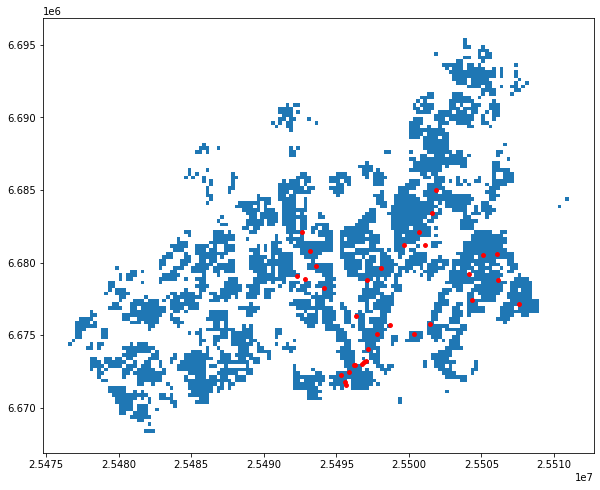

In [20]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(15,8))

# Plot population grid
pop.plot(ax=ax)

# Plot points
addresses.plot(ax=ax, color='red', markersize=15);

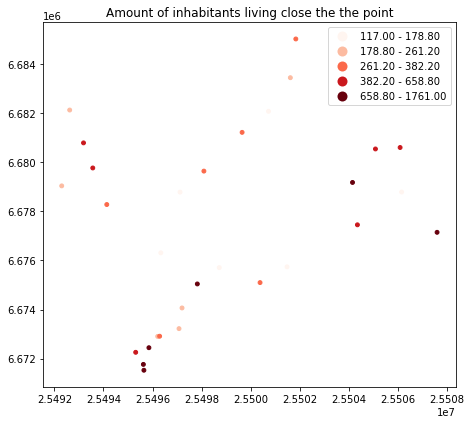

In [21]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10,6))

# Plot the points with population info
join.plot(ax=ax, column='pop18', cmap="Reds", markersize=15, scheme='quantiles', legend=True);

# Add title
plt.title("Amount of inhabitants living close the the point");

# Remove white space around the figure
plt.tight_layout()

In [22]:
# Output path
outfp = 'L3_data/addresses_population.shp'

# Save to disk
join.to_file(outfp)